In [43]:
import re
from random import randint
from urllib.parse import urlparse, urlsplit
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tld
import numpy as np

from pprint import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from xgboost import XGBClassifier, XGBModel
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier

# AC209 Component
from sklearn.neural_network import MLPClassifier


pd.options.display.max_columns=300

Loading Dataset. 
Source: [kaggle](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset?datasetId=1486586&sortBy=voteCount)

In [44]:
# Reading in the data
data = pd.read_csv("./malicious_phish.csv")

data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


# Table of Contents  

[EDA](#EDA)  
[Investigating Missing Data](#investigating-missing-data)   
[Feature Engineering](#feature-engineering)   
[Exploring Features](#exploring-features)   
[One Hot Encoding](#one-hot-encode-and-drop-categorical-columns)  
[Train Test Split](#train-test-split)   
[Baseline Modeling](#baseline-modeling)   
[Hyperparameter Tuning](#hyperparameter-tuning)  
[Other models](#other-models)  
[Results of Tuned Models](#results-of-tuned-models)  
[Going further](#going-further)

# EDA

In [45]:
# getting an idea of how many features and observations we have
data.shape

(651191, 2)

In [46]:
# distribution of classifications 
count_by_type = data.groupby("type").count().reset_index().sort_values("url", ascending=False)
count_by_type


,type,url
0,benign,428103
1,defacement,96457
3,phishing,94111
2,malware,32520


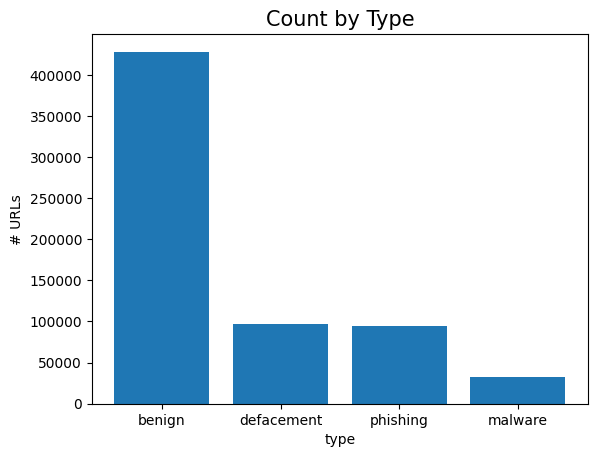

In [47]:
# plot distribution of classifications
plt.bar(count_by_type["type"], count_by_type["url"])
plt.xlabel("type")
plt.ylabel("# URLs")
plt.title("Count by Type", fontsize = 15)
plt.show()

## Investigating Missing Data

In [48]:
# investigate missing data
data.isna().sum()

url     0
type    0
dtype: int64

There is no missing data.

## Feature Engineering

In [49]:
# url length
data["url_length"] = data["url"].apply(lambda url : len(url))
data.head(5)


,url,type,url_length
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235


In [50]:
# reference: https://www.kaggle.com/code/hamzamanssor/detection-malicious-url-using-ml-models

symbols = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for symbol in symbols:
    data[symbol] = data['url'].apply(lambda i: i.count(symbol))

data.head()

,url,type,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1


In [51]:
def get_tld(url):
    try:
        return tld.get_tld(url, fail_silently=True, fix_protocol=True)
    except ValueError:
        return None


data["tld"] = data["url"].apply(lambda x: get_tld(x))
data.head()


,url,type,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,tld
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0,com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0,com
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0,org
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1,be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1,net


In [52]:
# reference: https://www.kaggle.com/code/sid321axn/malicious-url-detection-using-ml-feat-engg

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

data.head()

,url,type,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,tld,abnormal_url
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0,com.br,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0,com,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0,org,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1,be,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1,net,1


In [53]:
# reference: https://www.kaggle.com/code/hamzamanssor/detection-malicious-url-using-ml-models
def http_secure(url):
    http = urlparse(url).scheme
    match = str(http)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

data["https"] = data["url"].apply(lambda x : http_secure(x))
data.head(10)

,url,type,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,tld,abnormal_url,https
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0,com.br,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0,com,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0,org,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1,be,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1,net,1,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118,0,0,16,0,2,0,0,0,0,0,0,0,1,net,1,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45,0,0,1,0,2,0,0,0,0,0,0,0,0,com,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,46,0,1,2,1,1,0,0,0,0,0,0,0,0,com,0,0
8,http://www.pashminaonline.com/pure-pashminas,defacement,44,0,0,1,0,2,0,0,0,0,0,0,0,1,com,1,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,45,0,0,4,0,1,0,0,0,0,0,0,0,0,com,0,0


## Exploring Features

### Url Length : `url_length`

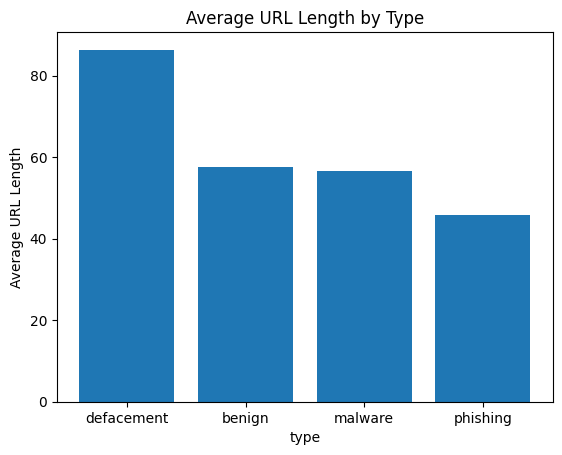

In [54]:
avg_url_length_by_type = data.groupby("type").agg({"url_length":"mean"}).sort_values("url_length", ascending=False).reset_index()

plt.bar(avg_url_length_by_type["type"], avg_url_length_by_type["url_length"])
plt.xlabel("type")
plt.ylabel("Average URL Length")
plt.title("Average URL Length by Type")
plt.show()

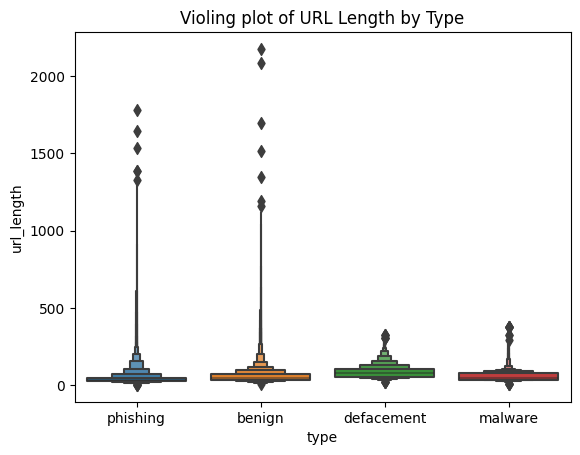

In [55]:
sns.boxenplot(data=data, x="type", y="url_length").set(title='Violing plot of URL Length by Type');


### Top Level Domains : `tld`

In [56]:
tld_percent_breakdown = (
    data.groupby("tld")
    .size()
    .reset_index(name="counts")
    .sort_values("counts", ascending=False)
)

tld_percent_breakdown["cumulative_sum"] = tld_percent_breakdown["counts"].sum()

tld_percent_breakdown["percent_of_total"] = (
    tld_percent_breakdown["counts"] / tld_percent_breakdown["cumulative_sum"]
)

tld_percent_breakdown["cumulative_percent"] = tld_percent_breakdown[
    "percent_of_total"
].cumsum()

tld_percent_breakdown.loc[
    tld_percent_breakdown["cumulative_percent"] > 0.95, "tld"
] = "other"

tld_percent_breakdown.reset_index()

tld_percent_breakdown = (
    tld_percent_breakdown.groupby("tld")
    .agg({"percent_of_total": "sum", "percent_of_total": "sum"})
    .sort_values("percent_of_total", ascending=False)
    .reset_index()
)

tld_percent_breakdown.head(10)


,tld,percent_of_total
0,com,0.609505
1,org,0.079091
2,other,0.051046
3,net,0.043956
4,de,0.020955
5,edu,0.015780
6,co.uk,0.015653
7,ca,0.014766
8,blogspot.com,0.012933
9,com.br,0.012248


/var/folders/zx/8fkyg89d7dzf10qpqzjf64840000gq/T/ipykernel_78126/3884717640.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0%}'.format(y) for y in y_values])


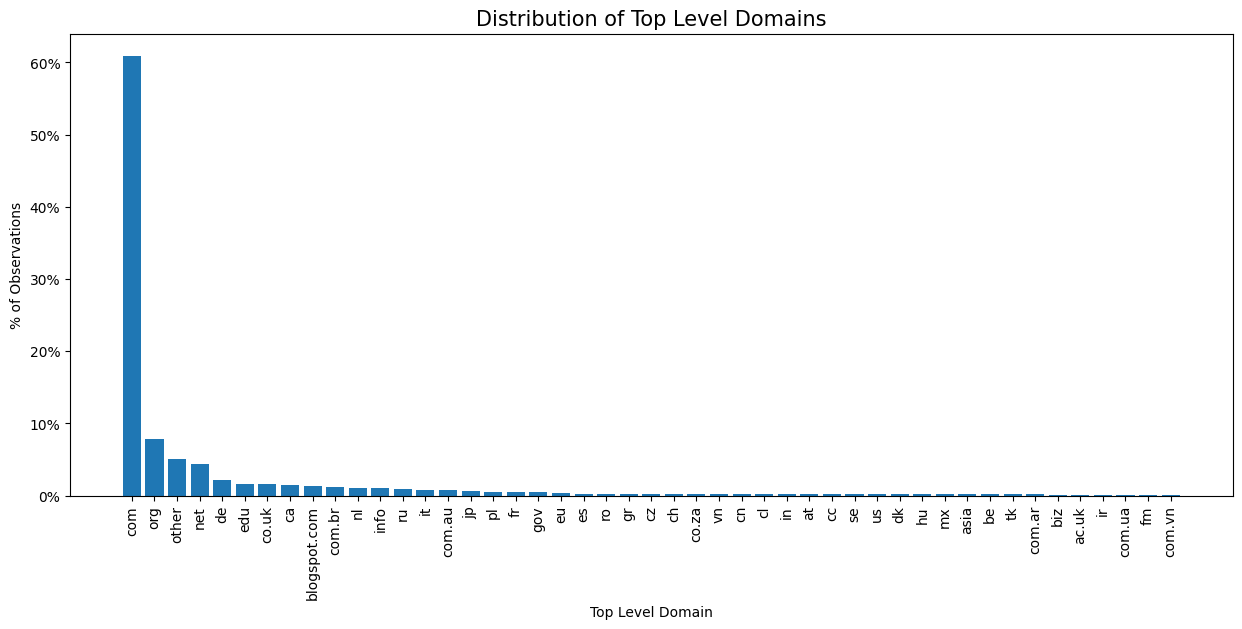

In [57]:
plt.figure(figsize=(15,6))
plt.bar(tld_percent_breakdown["tld"], tld_percent_breakdown["percent_of_total"])
plt.xticks(rotation = 90)
plt.xlabel("Top Level Domain")
plt.ylabel("% of Observations")
plt.title("Distribution of Top Level Domains", fontsize=15)

# after plotting the data, format the labels
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(y) for y in y_values])

plt.show()


In [58]:
# row count by type and tld
by_tdl_by_type = data.groupby(["type", "tld"]).size().reset_index(name="counts").sort_values(
    ["type", "counts"], ascending=[False, False]
)

# cumulative sum by type
by_tdl_by_type = by_tdl_by_type.assign(
    regional_population=by_tdl_by_type.groupby("type")["counts"].transform("sum")
).sort_values(["type", "counts"], ascending=[False, False])


# percent of type belonging to the tld
by_tdl_by_type["regional_percent_distribution"] = by_tdl_by_type["counts"] / by_tdl_by_type["regional_population"]

by_tdl_by_type = by_tdl_by_type.assign(
    regional_cumulative_percent_distribution=by_tdl_by_type.groupby("type")["regional_percent_distribution"].cumsum()
).sort_values(["type", "regional_percent_distribution"], ascending=[False, False])



by_tdl_by_type.loc[
    by_tdl_by_type["regional_cumulative_percent_distribution"] > 0.85, "tld"
] = "other"

by_tdl_by_type.reset_index()

by_tdl_by_type = (
    by_tdl_by_type.groupby(["type","tld"])
    .agg({"regional_percent_distribution": "sum", "counts": "sum"})
    .sort_values(["type","regional_percent_distribution"], ascending=[False,False])
    .reset_index()
)

by_tdl_by_type.head()

,type,tld,regional_percent_distribution,counts
0,phishing,com,0.517471,48486
1,phishing,other,0.151839,14227
2,phishing,org,0.099490,9322
3,phishing,net,0.057045,5345
4,phishing,edu,0.033512,3140


In [59]:
# assign colors to each TDL
tld_list = by_tdl_by_type["tld"].unique()
n = len(tld_list)
colors = ['#%06X' % randint(0, 0xFFFFFF) for i in range(n)]


color_dict = {tld:color for tld,color in zip(tld_list,colors)}
by_tdl_by_type["color"] = by_tdl_by_type["tld"].apply(lambda x : color_dict[x])
by_tdl_by_type.head()

,type,tld,regional_percent_distribution,counts,color
0,phishing,com,0.517471,48486,#74179C
1,phishing,other,0.151839,14227,#2DE967
2,phishing,org,0.099490,9322,#B2BF91
3,phishing,net,0.057045,5345,#D8B8D1
4,phishing,edu,0.033512,3140,#829106


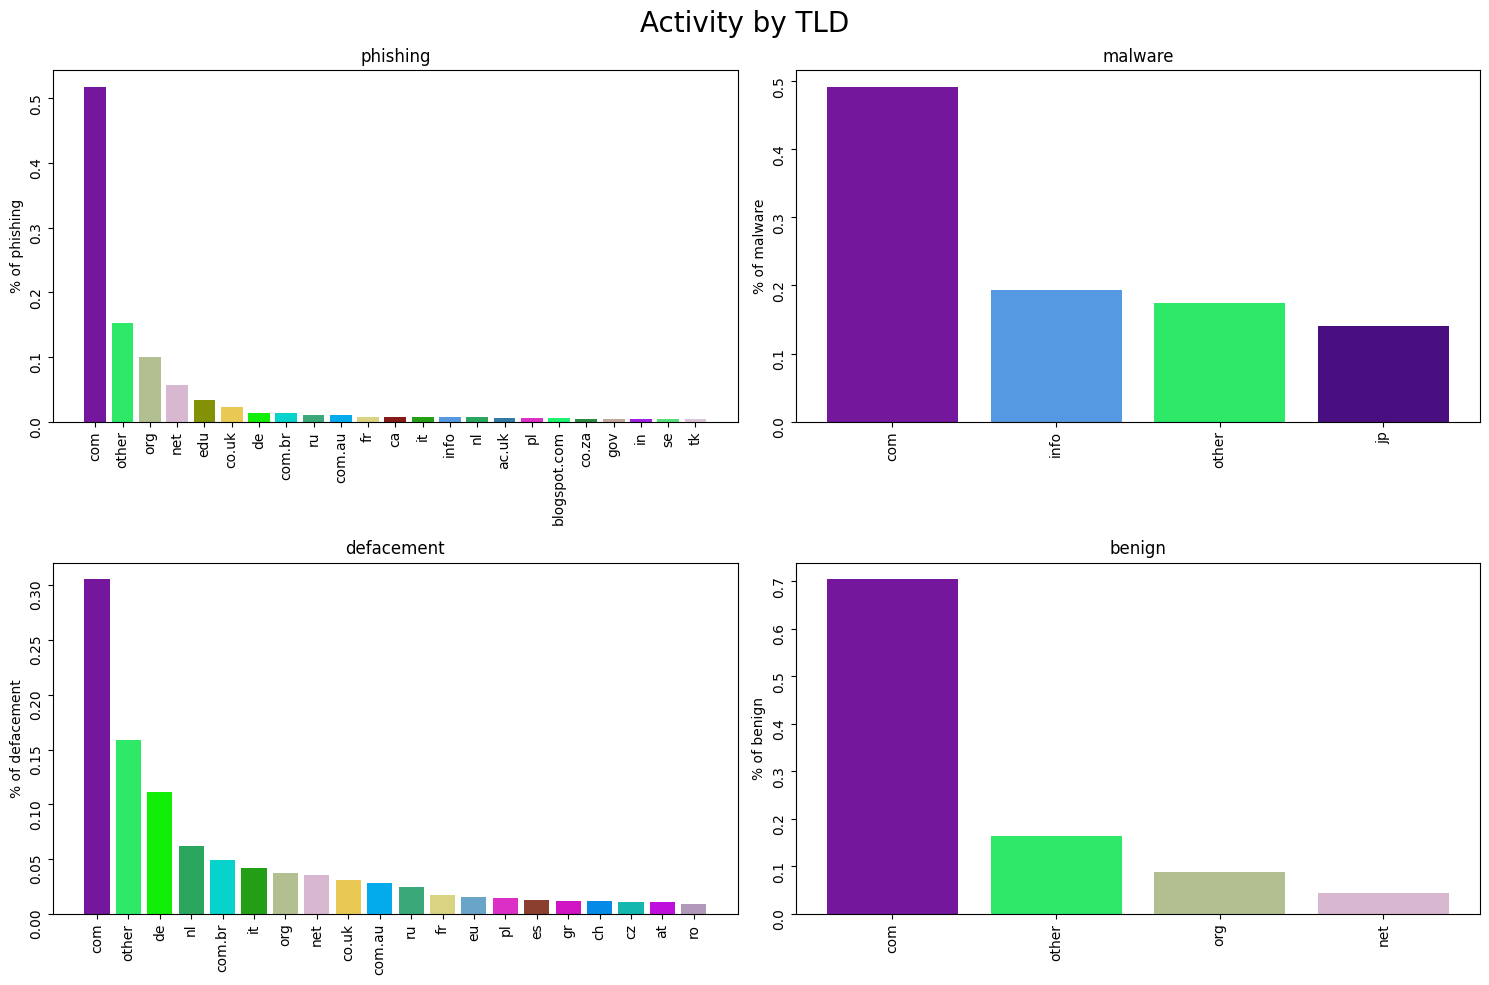

In [60]:
class_types = by_tdl_by_type["type"].unique()

fig , axes = plt.subplots(nrows= 2, ncols=2, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    df = by_tdl_by_type[by_tdl_by_type["type"]==class_types[i]]

    ax.bar(df["tld"], df["regional_percent_distribution"], color=df["color"])

    ax.set_title(class_types[i])
    ax.set_ylabel(f"% of {class_types[i]}")
    # ax.set_yticklabels(['{:,.0%}'.format(y) for y in df["regional_percent_distribution"]]) # TODO Fix % format
    ax.tick_params(labelrotation=90)

plt.suptitle("Activity by TLD", fontsize=20)
plt.tight_layout()

From the above we observe:
- '.com' is the most frequently appearing tld in general
- '.org' is the more common for phishing and benign, than for defacement , and malware
- 'defacement' and 'phishing' are the only categories that have a lot of countries
- '.info' tdl are targeted by malware more frequently than any other attack


### Parse URL Words : `words`

In [61]:
# Define a function to parse URL words

def parse_url_words(url):
    parsed_url = tld.parse_tld(url)
    parsed_url = [word for word in parsed_url if word is not None]
    parsed_url = [word for word in parsed_url if word != "www"]
    parsed_url = [word for word in parsed_url if not tld.is_tld(word)]
    parsed_url = [word.strip() for word in parsed_url]
    parsed_url = [word for word in parsed_url if word != '']
    parsed_url = None if len(parsed_url) == 0 else parsed_url
    return parsed_url
    
# Mapping it to our dataframe
data["words"] = data["url"].apply(lambda x : parse_url_words(x))
data.head(20)

,url,type,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,tld,abnormal_url,https,words
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0,com.br,0,0,None
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0,com,0,0,None
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0,org,0,0,None
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1,be,1,0,[garage-pirenne]
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1,net,1,0,[adventure-nicaragua]
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118,0,0,16,0,2,0,0,0,0,0,0,0,1,net,1,0,[buzzfil]
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45,0,0,1,0,2,0,0,0,0,0,0,0,0,com,0,0,None
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,46,0,1,2,1,1,0,0,0,0,0,0,0,0,com,0,0,None
8,http://www.pashminaonline.com/pure-pashminas,defacement,44,0,0,1,0,2,0,0,0,0,0,0,0,1,com,1,0,[pashminaonline]
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,45,0,0,4,0,1,0,0,0,0,0,0,0,0,com,0,0,None


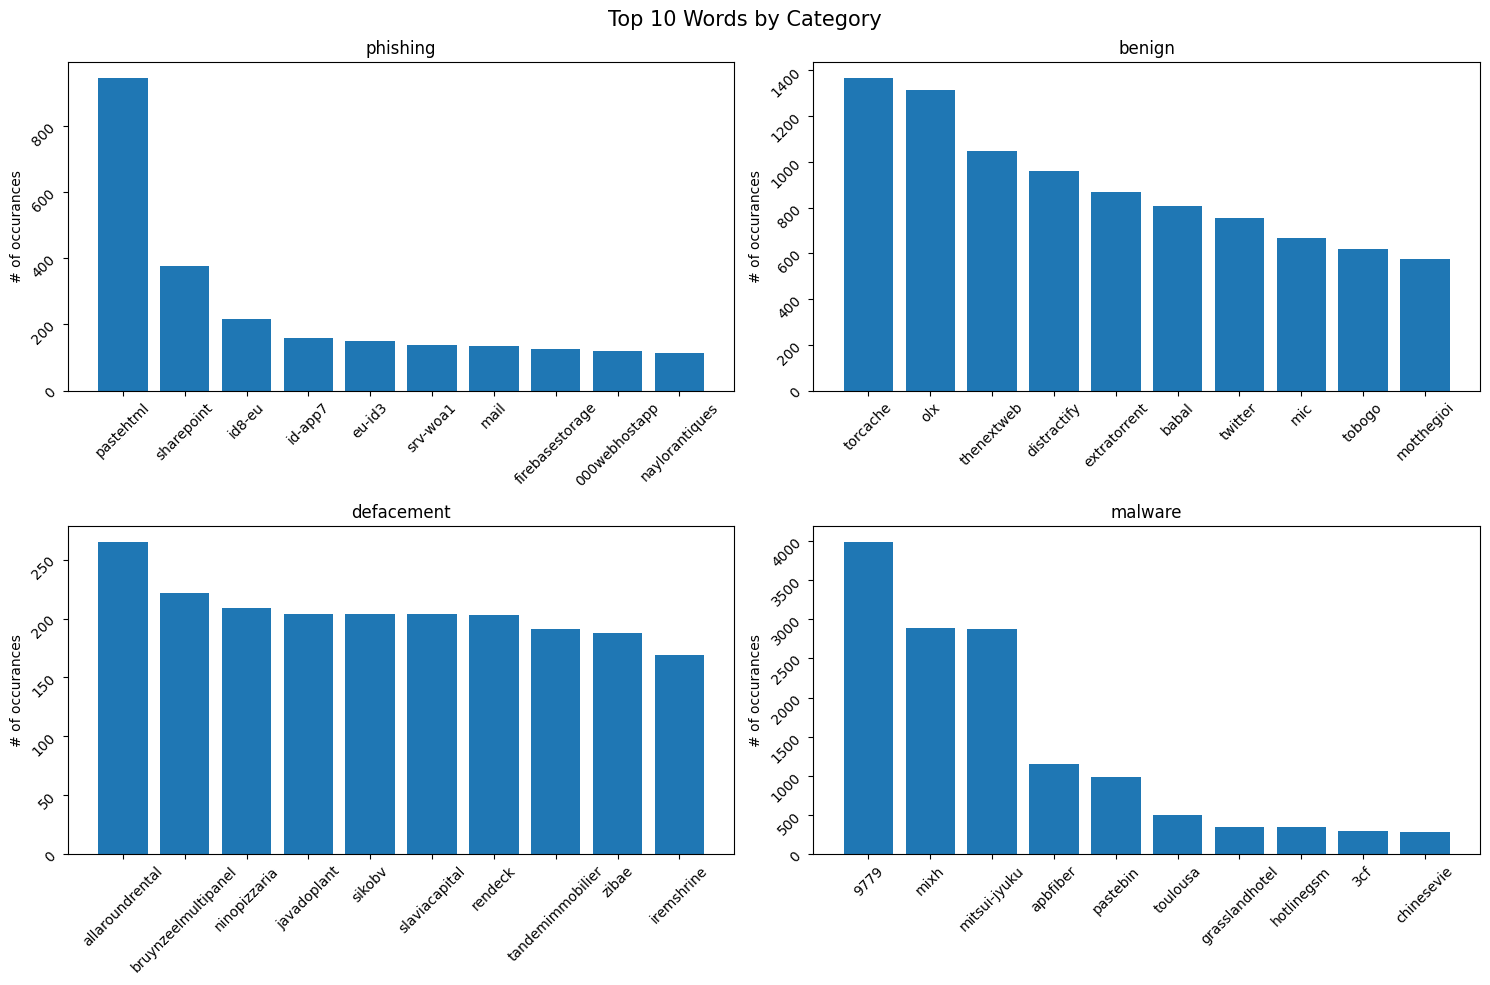

In [62]:

# count the most common words by category
words_by_category = (data.explode("words")
.groupby(["words", "type"])
.size()
.reset_index(name="counts")
.sort_values(["type","counts"], ascending=False)
)

words_by_category

# top 10 words by category

words_by_category["type_rank"] = (words_by_category
                                    .groupby(["type"])["counts"]
                                    .rank(ascending=False)
                                    
                                 )

top_10_words_by_category = words_by_category.query("type_rank <= 10").reset_index()

top_10_words_by_category

fig, axes = plt.subplots(2,2, figsize = (15,10))

categories = data["type"].unique()

for ax, category in zip(axes.flatten(),categories):
    df = top_10_words_by_category.query("type == @category")
    df = df.query("counts > 100")
    
    ax.bar(df["words"], df["counts"])
    ax.set_title(category)
    ax.set_ylabel(f"# of occurances")
#   ax.set_yticklabels(['{:,.0%}'.format(y) for y in df["regional_percent_distribution"]]) # TODO Fix % format
    ax.tick_params(labelrotation=45)
    
plt.suptitle("Top 10 Words by Category", fontsize = 15)    
plt.tight_layout()


In [63]:
# Retrieve top 10 words

top_phishing_words =  top_10_words_by_category.query("type == 'phishing'")["words"].to_list()
top_defacement_words =  top_10_words_by_category.query("type == 'defacement'")["words"].to_list()
top_malware_words =  top_10_words_by_category.query("type == 'malware'")["words"].to_list()
top_benign_words =  top_10_words_by_category.query("type == 'benign'")["words"].to_list()



def count_words_in_common(left_group, right_group):
    if left_group is not None:
        left_group = set(left_group)
        right_group = set(right_group)

        intersection = left_group.intersection(right_group)

        return len(intersection)
    else:
        return 0
    



In [64]:
# one hot encode top words
data["phishing_words_count"] = data["words"].apply(lambda x: count_words_in_common(x,top_phishing_words))
data["defacement_words_count"] = data["words"].apply(lambda x: count_words_in_common(x,top_defacement_words))
data["malware_words_count"] = data["words"].apply(lambda x: count_words_in_common(x,top_malware_words))
data["benign_words_count"] = data["words"].apply(lambda x: count_words_in_common(x,top_benign_words))

## One Hot Encode and Drop Categorical Columns

In [65]:
tld_of_interest = by_tdl_by_type["tld"].unique()
tld_of_interest

array(['com', 'other', 'org', 'net', 'edu', 'co.uk', 'de', 'com.br', 'ru',
       'com.au', 'fr', 'ca', 'it', 'info', 'nl', 'ac.uk', 'pl',
       'blogspot.com', 'co.za', 'gov', 'in', 'se', 'tk', 'jp', 'eu', 'es',
       'gr', 'ch', 'cz', 'at', 'ro'], dtype=object)

In [66]:
# one hot encode TLD
tld_of_interest = by_tdl_by_type["tld"].unique()

for tld in tld_of_interest:
    data[tld] = data["tld"].apply(lambda x : 1 if x == tld else 0)

data.head()

,url,type,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,tld,abnormal_url,https,words,phishing_words_count,defacement_words_count,malware_words_count,benign_words_count,com,other,org,net,edu,co.uk,de,com.br,ru,com.au,fr,ca,it,info,nl,ac.uk,pl,blogspot.com,co.za,gov,in,se,tk,jp,eu,es,gr,ch,cz,at,ro
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0,com.br,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0,com,0,0,None,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0,org,0,0,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1,be,1,0,[garage-pirenne],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1,net,1,0,[adventure-nicaragua],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
# one hot encode response type
one_hot = pd.get_dummies(data['type'])

# Join the encoded df
data = data.join(one_hot)
data.head()

,url,type,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,tld,abnormal_url,https,words,phishing_words_count,defacement_words_count,malware_words_count,benign_words_count,com,other,org,net,edu,co.uk,de,com.br,ru,com.au,fr,ca,it,info,nl,ac.uk,pl,blogspot.com,co.za,gov,in,se,tk,jp,eu,es,gr,ch,cz,at,ro,benign,defacement,malware,phishing
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0,com.br,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0,com,0,0,None,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0,org,0,0,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1,be,1,0,[garage-pirenne],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1,net,1,0,[adventure-nicaragua],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [68]:
data.drop(['url', 'type', 'tld', 'words'], inplace=True, axis=1)
data.head()

,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,phishing_words_count,defacement_words_count,malware_words_count,benign_words_count,com,other,org,net,edu,co.uk,de,com.br,ru,com.au,fr,ca,it,info,nl,ac.uk,pl,blogspot.com,co.za,gov,in,se,tk,jp,eu,es,gr,ch,cz,at,ro,benign,defacement,malware,phishing
0,16,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,35,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,31,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,88,0,1,1,4,3,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,235,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Train-Test Split

In [69]:
data.shape

(651191, 55)

In [70]:
response1 = "phishing"
response2 = "malware"
response3 = "defacement"
response4 = "benign"
predictors = data.drop([response1, response2, response3, response4], axis="columns").columns.to_list()

response_variables = [response1, response2, response3, response4]

(X_train, X_test,
 y_train1, y_test1,
 y_train2, y_test2,
 y_train3, y_test3,
 y_train4, y_test4,
 )  = train_test_split(data[predictors], 
                       data[response1], 
                       data[response2], 
                       data[response3], 
                       data[response4], 
                       train_size=0.80, 
                       random_state = 109, 
                      stratify=data[response_variables])



# Baseline Modeling

###  Logistic Regression (One v.s. Others)

#### Phishing vs Others
- $P(Y=1)$ indicates Phishing
- $P(Y=0)$ not  Phishing (any other category)

In [71]:
%%time

# We first fit a logistic regression without specifying any penalty
logistic_reg = LogisticRegression(penalty="none", 
                                  class_weight="balanced",
                                  max_iter=10_000)


# predict phishing or not phishing
logistic_reg.fit(X_train, y_train1)

print("Phishing Train Score : ")
print(logistic_reg.score(X_train, y_train1))


print("Phishing Test Score: ")
print(logistic_reg.score(X_test, y_test1))
lr_score_phishing = logistic_reg.score(X_test, y_test1)


Phishing Train Score : 
0.6498890492790123
Phishing Test Score: 
0.6521855972481361
CPU times: user 7min 49s, sys: 41.5 s, total: 8min 31s
Wall time: 59.5 s


In [72]:
print('Logistic Regression odds-ratios for Phishing:')
phishing_results = {k:[v] for k, v in zip(data.columns, np.exp(logistic_reg.coef_[0]))}
pd.DataFrame.from_dict(phishing_results)

Logistic Regression odds-ratios for Phishing:


,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,phishing_words_count,defacement_words_count,malware_words_count,benign_words_count,com,other,org,net,edu,co.uk,de,com.br,ru,com.au,fr,ca,it,info,nl,ac.uk,pl,blogspot.com,co.za,gov,in,se,tk,jp,eu,es,gr,ch,cz,at,ro
0,0.991675,7.322692,0.457135,0.718525,0.739164,1.380552,14.837918,0.907482,0.287586,6.991024,0.686245,3.562137,1.251756,9.090014,0.13229,70.803663,36388.043611,0.016398,0.000004,0.000606,0.735411,1.0,0.939206,1.372997,1.357006,0.876736,0.809331,0.835683,1.117916,0.859075,2.005532,0.368602,0.674523,1.460347,0.454225,4.596546,0.827807,0.166153,1.450487,0.554477,2.338275,2.243649,2.206286,1.1972,0.520367,1.375454,0.716069,1.013082,0.545477,0.517339,1.334066


#### Malware vs Others
- $P(Y=1)$ indicates Malware
- $P(Y=0)$ not Malware

In [73]:
%%time

# predict malware or not malware
logistic_reg.fit(X_train, y_train2)

print("Malware Train Score: ")
print(logistic_reg.score(X_train, y_train2))


print("Malware Test Score: ")
print(logistic_reg.score(X_test, y_test2))
lr_score_malware = logistic_reg.score(X_test, y_test2)

Malware Train Score: 
0.9063483775856509
Malware Test Score: 
0.9054507482397746
CPU times: user 11min 52s, sys: 47.3 s, total: 12min 40s
Wall time: 1min 23s


In [74]:
print('Logistic Regression odds-ratios for Malware:')
malware_results = {k:[v] for k, v in zip(data.columns, np.exp(logistic_reg.coef_[0]))}
pd.DataFrame.from_dict(malware_results)

Logistic Regression odds-ratios for Malware:


,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,phishing_words_count,defacement_words_count,malware_words_count,benign_words_count,com,other,org,net,edu,co.uk,de,com.br,ru,com.au,fr,ca,it,info,nl,ac.uk,pl,blogspot.com,co.za,gov,in,se,tk,jp,eu,es,gr,ch,cz,at,ro
0,0.977629,0.300879,0.437248,0.788966,1.126684,1.477081,0.053545,1.068008,1.066418,0.522988,9.259899,0.507137,0.044254,1.401442,60.923921,2.04041,0.015376,0.001785,281804.773748,0.015965,0.541631,1.0,0.13966,0.285708,0.036758,0.075873,0.020118,0.022094,0.387873,0.018367,0.02499,0.248555,0.015964,0.25174,0.049253,0.007516,0.04198,0.01257,1.138122,0.012462,0.652427,0.052303,4.963787,0.159674,0.120603,0.026492,0.011389,0.03813,0.049608,0.014513,0.03259


#### Defacement vs Others
- $P(Y=1)$ indicates Defacement
- $P(Y=0)$ not Defacement

In [75]:
%%time

# predict defacement or not defacement
logistic_reg.fit(X_train, y_train3)

print("Defacement Train Score: ")
print(logistic_reg.score(X_train, y_train3))


print("Defacement Test Score: ")
print(logistic_reg.score(X_test, y_test3))
lr_score_defacement = logistic_reg.score(X_test, y_test3)

Defacement Train Score: 
0.9197258096715244
Defacement Test Score: 
0.9199625304248343
CPU times: user 8min 55s, sys: 36.3 s, total: 9min 32s
Wall time: 1min 2s


In [76]:
print('Logistic Regression odds-ratios for Defacement:')
defacement_results = {k:[v] for k, v in zip(data.columns, np.exp(logistic_reg.coef_[0]))}
pd.DataFrame.from_dict(defacement_results)

Logistic Regression odds-ratios for Defacement:


,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,phishing_words_count,defacement_words_count,malware_words_count,benign_words_count,com,other,org,net,edu,co.uk,de,com.br,ru,com.au,fr,ca,it,info,nl,ac.uk,pl,blogspot.com,co.za,gov,in,se,tk,jp,eu,es,gr,ch,cz,at,ro
0,0.990672,0.001267,1.359407,0.931387,1.636129,1.085663,0.134453,0.842215,0.658236,0.325717,0.165591,1.073381,3.156867,0.00136,1.372979e+09,1.046322e-08,0.000043,360.617919,0.000009,1.851251e-07,2.053414,1.0,4.833068,2.173301,0.260878,10.779619,34.630064,6.93958,5.933571,42.839056,7.867923,5.748741,23.630382,4.947413,118.631218,53.680551,2.127483,0.009183,2.775656,0.521868,0.880193,20.536505,0.073527,0.362686,21.31509,37.602,19.75866,80.709914,47.262914,129.104617,17.386672


#### Benign vs Others
- $P(Y=1)$ indicates Benign
- $P(Y=0)$ not Benign

In [77]:
%%time

# predict benign or not
logistic_reg.fit(X_train, y_train4)

print("Benign Train Score: ")
print(logistic_reg.score(X_train, y_train4))


print("Benign Test Score: ")
print(logistic_reg.score(X_test, y_test4))
lr_score_benign = logistic_reg.score(X_test, y_test4)

Benign Train Score: 
0.8652255870022574
Benign Test Score: 
0.8655778990932056
CPU times: user 11min 50s, sys: 55.8 s, total: 12min 46s
Wall time: 1min 25s


In [78]:
print('Logistic Regression odds-ratios for Benign:')
benign_results = {k:[v] for k, v in zip(data.columns, np.exp(logistic_reg.coef_[0]))}
pd.DataFrame.from_dict(benign_results)

Logistic Regression odds-ratios for Benign:


,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,phishing_words_count,defacement_words_count,malware_words_count,benign_words_count,com,other,org,net,edu,co.uk,de,com.br,ru,com.au,fr,ca,it,info,nl,ac.uk,pl,blogspot.com,co.za,gov,in,se,tk,jp,eu,es,gr,ch,cz,at,ro
0,1.031285,0.946729,4.841602,1.374474,0.565105,0.576857,0.122986,1.10548,1.759974,0.032492,0.525928,0.404637,0.535299,1.606,0.002053,0.40253,5.272216e-07,0.001464,0.00044,120375.85673,1.902365,1.0,1.369608,1.105967,1.081038,1.161545,0.228376,1.036396,0.907264,0.654651,0.408567,3.509071,0.320523,0.898499,0.218323,0.254532,3.569836,26.459189,1.015652,2.89231,1.134913,0.169379,0.805621,32.901574,0.735824,0.121401,0.355119,0.286684,0.582942,0.470386,0.307276


## Decision Tree Classifier

In [79]:
# We need to re-split the data as we had originally split it into 4 response variables

# Train-test split without distinguishing between responses:

# Combine all of our target varibales into 1, as opposed to previously
dependent_variables = [response1, response2, response3, response4]

# Drop dependent variables from the rest of dataframe
predictors = data.drop(dependent_variables, 
                       axis="columns").columns.to_list()

# 80% train size
(X_train, X_test,
 y_train, y_test)  = train_test_split(
                                      data[predictors], 
                                      data[dependent_variables], 
                                      train_size=0.80, random_state=109, 
                                      stratify = data[dependent_variables]
                                     )

In [80]:
# We need a list of values that gives us a numeric classification of what was in the 
# `type` column
# This is particularly relevant to models such as AdaBoost and Multinomial Logit, 
# who only take a 1-dimensional array as input

numerical_y_train = []
numerical_y_test = []

# Numeric equivalent of `train` labels
for row in y_train.values:
    if row[0] == 1:
        numerical_y_train.append(1)
    elif row[1] == 1:
        numerical_y_train.append(2)
    elif row[2] == 1:
        numerical_y_train.append(3)
    else:
        numerical_y_train.append(0)
        
# Numeric equival of `test` labels       
for row in y_test.values:
    if row[0] == 1:
        numerical_y_test.append(1)
    elif row[1] == 1:
        numerical_y_test.append(2)
    elif row[2] == 1:
        numerical_y_test.append(3)
    else:
        numerical_y_test.append(0)

In [81]:
%%time
# Initialise Decision Tree without any tuning 

clf = DecisionTreeClassifier()

# Fit on training data
clf = clf.fit(X_train, y_train)

# Use to issue predictions:
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

# Score!
print("Un-tuned Dtree Classifier Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Un-tuned Dtree Classifier Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Un-tuned Dtree Classifier F1-Score:", f1_score(y_test, clf.predict(X_test), 
                                                      average='weighted'))
dtree_score = accuracy_score(y_test, y_test_pred)
dtree_f1_score = f1_score(y_test, clf.predict(X_test), average='weighted')

Un-tuned Dtree Classifier Train Accuracy: 0.9018738770558516
Un-tuned Dtree Classifier Test Accuracy: 0.8841284100768587
Un-tuned Dtree Classifier F1-Score: 0.8811212498548351
CPU times: user 2.35 s, sys: 48.8 ms, total: 2.4 s
Wall time: 2.4 s


In [82]:
# Function to retrieve non-numeric labels for our true values and predictions

def get_pred(row):
    
    if row[0] == 1:
        return 'phishing'
    elif row[1] == 1:
        return 'malware'
    elif row[2] == 1:
        return 'defacement'
    else:
        return 'benign'

In [83]:
# Lists where we append predicted and actual labels based on output of function above
predicted_labels = []
actual_labels = []

for i in y_test_pred:
    predicted_labels.append(get_pred(i))

for i in y_test.values:
    actual_labels.append(get_pred(i))
    
# Creating the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=dependent_variables)
cm

array([[ 9120,   258,   907,  8537],
       [  206,  5774,   199,   325],
       [  427,   247, 18078,   540],
       [ 2771,    52,   137, 82661]])

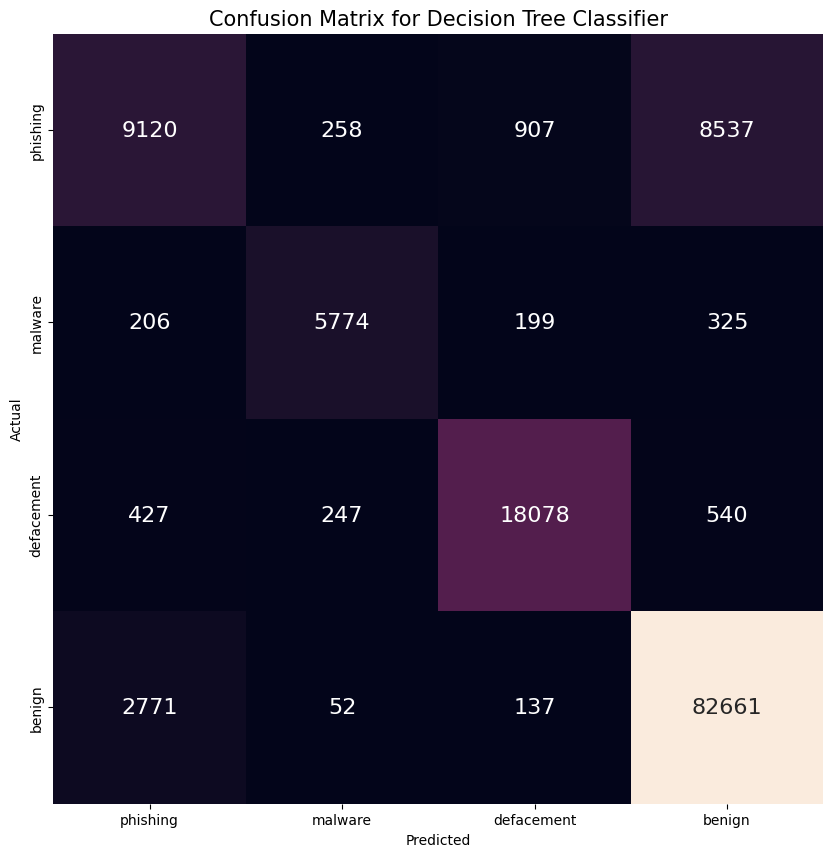

In [84]:
labels = dependent_variables
df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix for Decision Tree Classifier', fontsize=15)
ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 4) 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
ax.invert_yaxis() 
plt.show()

In [85]:
# Classification report:
print('\nClassification Report Decision Tree\n')
print(classification_report(actual_labels, predicted_labels))


Classification Report Decision Tree

              precision    recall  f1-score   support

      benign       0.90      0.97      0.93     85621
  defacement       0.94      0.94      0.94     19292
     malware       0.91      0.89      0.90      6504
    phishing       0.73      0.48      0.58     18822

    accuracy                           0.89    130239
   macro avg       0.87      0.82      0.84    130239
weighted avg       0.88      0.89      0.88    130239



## Random Forest Classifier

Random forest classifiers are a type of ensemble learning algorithm, meaning that they combine the predictions of multiple individual models to make a final prediction. In the case of a random forest classifier, the individual models are decision trees, and the final prediction is made by aggregating the predictions of all the decision trees in the ensemble.

In [86]:
%%time
# Initializing random forest classifier:
rf_base = RandomForestClassifier()

# Fitting it on our data
rf_base = rf_base.fit(X_train, y_train)

# Issuing predictions
y_pred_train = rf_base.predict(X_train)
y_pred_test = rf_base.predict(X_test)

CPU times: user 1min 1s, sys: 1.11 s, total: 1min 2s
Wall time: 1min 2s


In [87]:
# Scoring Random Forest

print("Un-tuned RF Classifier Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Un-tuned RF Classifier Test Accuracy:", accuracy_score(y_test, y_pred_test))

rf_score = accuracy_score(y_test, y_pred_test)

Un-tuned RF Classifier Train Accuracy: 0.9059414303045195
Un-tuned RF Classifier Test Accuracy: 0.8916991070263132


In [88]:
# Inspecting feature importance

feature_imp = pd.Series(rf_base.feature_importances_, index=predictors).sort_values(ascending=False)
pd.DataFrame(feature_imp, columns=['Feature Importance Score']).head(5)

,Feature Importance Score
url_length,0.182158
abnormal_url,0.179191
//,0.146588
.,0.122461
=,0.064486


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


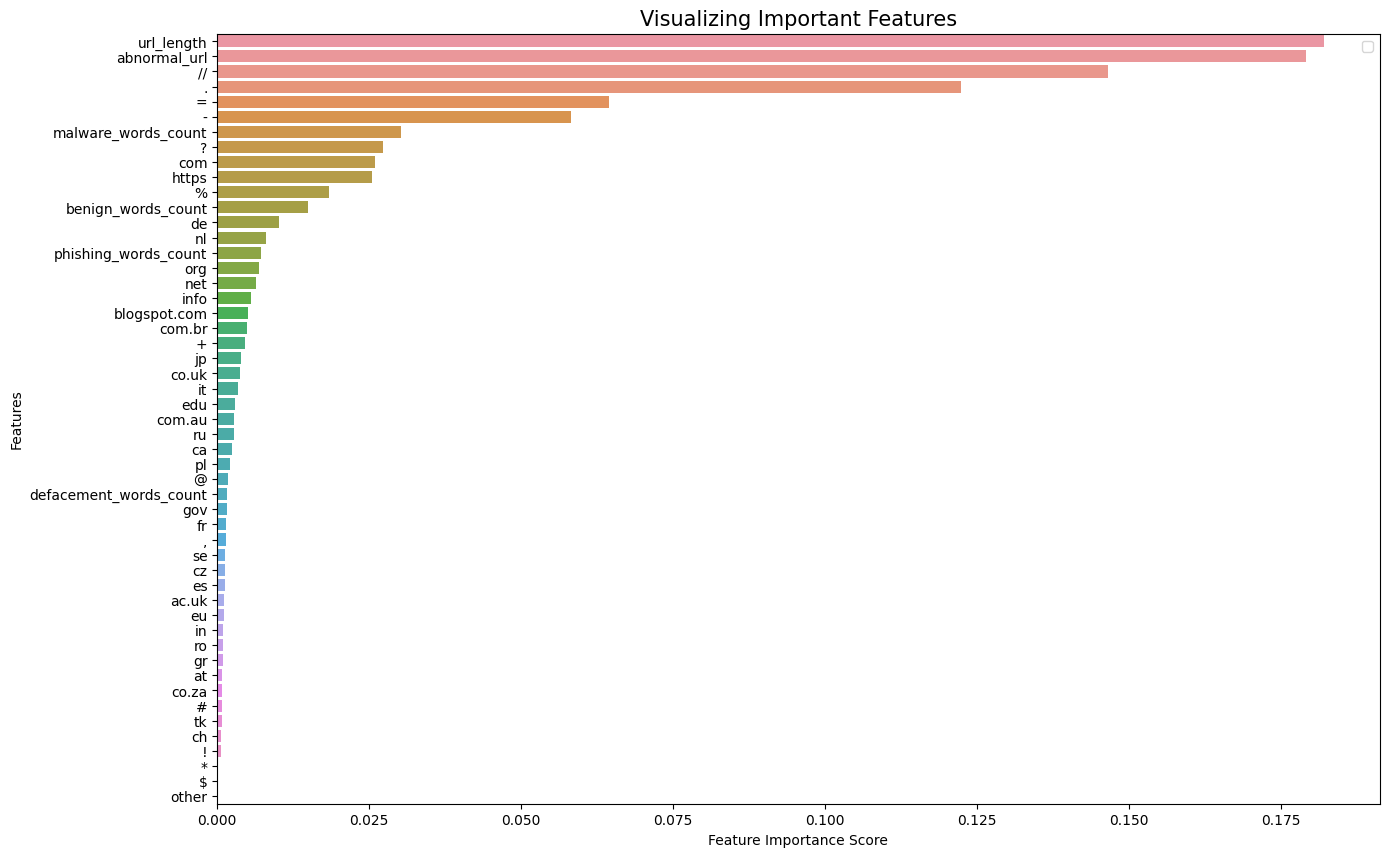

In [89]:
# Visualizing feature importance

# Creating a bar plot
plt.figure(figsize=(15,10))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", fontsize=15)
plt.legend()
plt.show()

In [90]:
# Creating the confusion matrix
cm_rf = confusion_matrix(actual_labels, [get_pred(i) for i in y_pred_test], labels=dependent_variables)
cm_rf

array([[ 9405,   206,   933,  8278],
       [  215,  5801,   197,   291],
       [  405,   230, 18286,   371],
       [ 2732,    35,   127, 82727]])

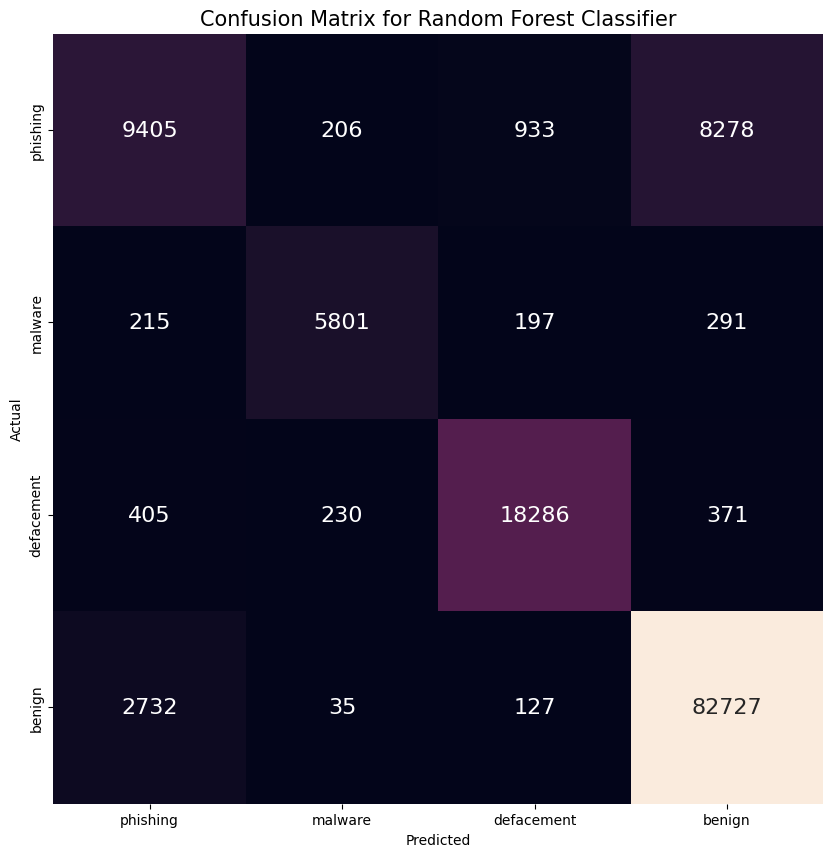

In [91]:
df_cm_rf = pd.DataFrame(cm_rf, labels, labels)
plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=15)
ax = sns.heatmap(df_cm_rf, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 4) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
ax.invert_yaxis() #optional
plt.show()

In [92]:
# Classification report:

print('\nClassification Report Random Forest\n')
print(classification_report(actual_labels, [get_pred(i) for i in y_pred_test]))


Classification Report Random Forest

              precision    recall  f1-score   support

      benign       0.90      0.97      0.93     85621
  defacement       0.94      0.95      0.94     19292
     malware       0.92      0.89      0.91      6504
    phishing       0.74      0.50      0.60     18822

    accuracy                           0.89    130239
   macro avg       0.88      0.83      0.84    130239
weighted avg       0.88      0.89      0.88    130239



# Reporting results of untuned model

In [93]:
print('RESULTS FOR UNTUNED MODELS:')
results_ = {
           'Logistic Regression: Phishing': lr_score_phishing, 
           'Logistic Regression: Malware':lr_score_malware,
           'Logistic Regression: Defacement':lr_score_defacement, 
           'Logistic Regression: Benign':lr_score_benign, 
           'Decision Tree Classifier': dtree_score, 
           'Random Forest Classifier':rf_score, 
           
            }

results_df = pd.DataFrame.from_dict(results_.items())
results_df.columns =['Model', 'Test Accuracy']
results_df = results_df.sort_values(by='Test Accuracy', ascending=False).reset_index().drop('index', axis=1)
results_df['Accuracy Ranking'] = range(1, len(results_df)+1)
results_df.set_index('Accuracy Ranking')

RESULTS FOR UNTUNED MODELS:


,Model,Test Accuracy
Accuracy Ranking,,
1,Logistic Regression: Defacement,0.919963
2,Logistic Regression: Malware,0.905451
3,Random Forest Classifier,0.891699
4,Decision Tree Classifier,0.884128
5,Logistic Regression: Benign,0.865578
6,Logistic Regression: Phishing,0.652186


# Hyperparameter Tuning

## Regularizing Logistic Regressions

Looking at our previous regression coefficients, it seems like many of these coefficients are suspiciously close to 0. There are not many large parameters of about the same value, which would justify Ridge regularisation.
This is why we opt for **Lasso** regularisation (`penalty = 'l1'`). We plan to implement this regression to shrink relatively insignificant regression coefficients to 0. 

Having a wide range of coefficients being close to 0 is potentially indicative of having at least one feature largely dominating the analysis. 

In [94]:
# Specifying that we want the Lasso penalty:
penalty = 'l1'

lasso_logistic_reg = LogisticRegression(penalty=penalty, 
                                  class_weight="balanced", 
                                  max_iter=10_000, 
                                        
                                  # 'liblinear solver is necessary in this case'
                                  solver = 'liblinear')


# predict phishing or not phishing
lasso_logistic_reg.fit(X_train, y_train1)

# Recording new test score
lasso_lr_score_phishing = logistic_reg.score(X_test, y_test1)

In [95]:
# We use Lasso regression to identify the features who have little weight in this regression
null_coefs_phishing = {k:[v] for k, v in zip(data.columns, 
                                          lasso_logistic_reg.coef_[0]) if v == 0}

In [96]:
# Specifying that we want the Lasso penalty:

# predict malware or not malware
lasso_logistic_reg.fit(X_train, y_train2)

# Recording accuracy
lasso_lr_score_malware = lasso_logistic_reg.score(X_test, y_test2)

In [97]:
# We use Lasso regression to identify the features who have little weight in this regression
null_coefs_malware = {k:[v] for k, v in zip(data.columns, 
                                          lasso_logistic_reg.coef_[0]) if v == 0}

In [98]:
# predict defacement or not defacement
lasso_logistic_reg.fit(X_train, y_train3)

# Recording accuraacy
lasso_lr_score_defacement = lasso_logistic_reg.score(X_test, y_test3)

In [99]:
# We use Lasso regression to identify the features who have little weight in this regression
null_coefs_defacement = {k:[v] for k, v in zip(data.columns, 
                                          lasso_logistic_reg.coef_[0]) if v == 0}

In [100]:
# predict benign or not 
lasso_logistic_reg.fit(X_train, y_train4)

# Recording accuracy
lasso_lr_score_benign = lasso_logistic_reg.score(X_test, y_test4)

In [101]:
# We use Lasso regression to identify the features who have little weight in this regression
null_coefs_benign = {k:[v] for k, v in zip(data.columns, 
                                          lasso_logistic_reg.coef_[0]) if v == 0}

In [102]:
# Function to calculate percentage increase for last column
perc_increase = lambda start_val, end_val: ((end_val-start_val)/start_val)*100

In [103]:
print('RESULTS FOR REGULARIZED MODELS:')
results_ = {
           'Logistic Regression: Phishing': [lr_score_phishing, 
                                             lasso_lr_score_phishing, 
                                             [i for i in null_coefs_phishing.keys()], 
                                            perc_increase(lr_score_phishing, lasso_lr_score_phishing)],
    
           'Logistic Regression: Malware':[lr_score_malware, 
                                           lasso_lr_score_malware, 
                                           [i for i in null_coefs_malware.keys()], 
                                          perc_increase(lr_score_malware, lasso_lr_score_malware)],
    
           'Logistic Regression: Defacement':[lr_score_defacement, lasso_lr_score_defacement, [i for i in null_coefs_defacement.keys()], 
                                              perc_increase(lr_score_defacement, lasso_lr_score_defacement)], 
    
           'Logistic Regression: Benign':[lr_score_benign, lasso_lr_score_benign, [i for i in null_coefs_benign.keys()], 
                                         perc_increase(lr_score_benign, lasso_lr_score_benign)]
            }

results_df = pd.DataFrame.from_dict(results_, orient='index')
results_df.columns =['Test Accuracy', 
                     'Test Accuracy Regularized', 
                     'Nullified Features', 
                     '% Accuracy Improvement from Regularization']
results_df

RESULTS FOR REGULARIZED MODELS:


,Test Accuracy,Test Accuracy Regularized,Nullified Features,% Accuracy Improvement from Regularization
Logistic Regression: Phishing,0.652186,0.322461,"[other, jp]",-50.556864
Logistic Regression: Malware,0.905451,0.905313,[other],-0.015264
Logistic Regression: Defacement,0.919963,0.919909,[other],-0.005842
Logistic Regression: Benign,0.865578,0.865570,"[other, co.za]",-0.000887


We can see here that Lasso significantly worsens the regression for `phishing`, has a marginally worse effect for `malware` and `defacement`, and only marginally increases `benign`. This casts doubt over the "One v.s. Rest" approach that we had originally opted for. This may be because one of our features is *dominating* the regressions. This feature not *having the same "predictive power"* across diffferent regressions is explanatory of why the accuracy for `phishing` was more heavily impacted than the others. 


Instead, we look to implement a **Multinomial Logistic Regression**, where instead we would be predicting the probability of a URL being anything else than `benign`, leaving `benign` as the "base class". 

This is mathematically equivalent to using the *softmax* function:

$$P(y=k) = \frac{e^{X\beta_k}} {\Sigma^K_{k=1} e^{X\beta_k}}$$

The loss function is then:

$$ L = - \Sigma_i \Sigma_k I(y_i = k) P (y_i = k)$$


Although the accuracy is quite similar between our two models (very similar results in terms of probability and classification, multinomial is slightly more efficient in terms of estimation since there are technically fewer parameters. In this setting, we found an application of this model more interesting than further tuning our OvR Logistic Regressions, as it is more suitable for inferences/group comparisons.

The accuracy obtained with the multinomial logit is $\approx 83.86%$. The overall poor performance of our Logistic Regressions in both settings seem to be attributed to limitations that are inherent to the model, which is in this case its *inability to efficiently capture complex decision boundaries*. It seems like the classification into various malicious categories is proving itself far too complex a task for such a simplistic model. 

This is the reason why we had resorted to ensemble methods in our previous section, and why we choose to opt for them again. We then proceed to fine tune our decision-tree classisifer as well as our random forest. 

In [105]:
# Takes a long time to run
# # Multinomial Logistic Regression, non-regularized

# #y_train_m = y_train.values.reshape(-1,1)

# #define the multinomial logistic regression model without a penalty
# multi_logit = LogisticRegression(
#                                  multi_class='multinomial', 
#                                  solver='newton-cg', 
#                                  penalty='none', 
#                                  max_iter=1000
#                                 )

# multi_logit = multi_logit.fit(X_train, numerical_y_train)
# print('Multinomial-logit test accuracy: {}'.format(multi_logit.score(X_test, numerical_y_test))) # 0.83 

## Cross-validation for `max-depth` of decision tree

Our `DecisionTreeClassifier` was among the top performing models without any tuning. To try and improve it, first consider its depth and perform cross-validation to find the optimal one. Highest mean cross-validation accuracy is obtained for `max_depth`$=23$. Our new test-set accuracy becomes $88.59%$, which is a $0.32%$ increase from the untuned accuracy. 
This being quite minor of an improvement suggests the need to tune additional parameters. This leads us to perform a gridsearch to tune the stopping conditions (see below).

In [63]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    
    return cv_scores_mean, cv_scores_std, accuracy_scores


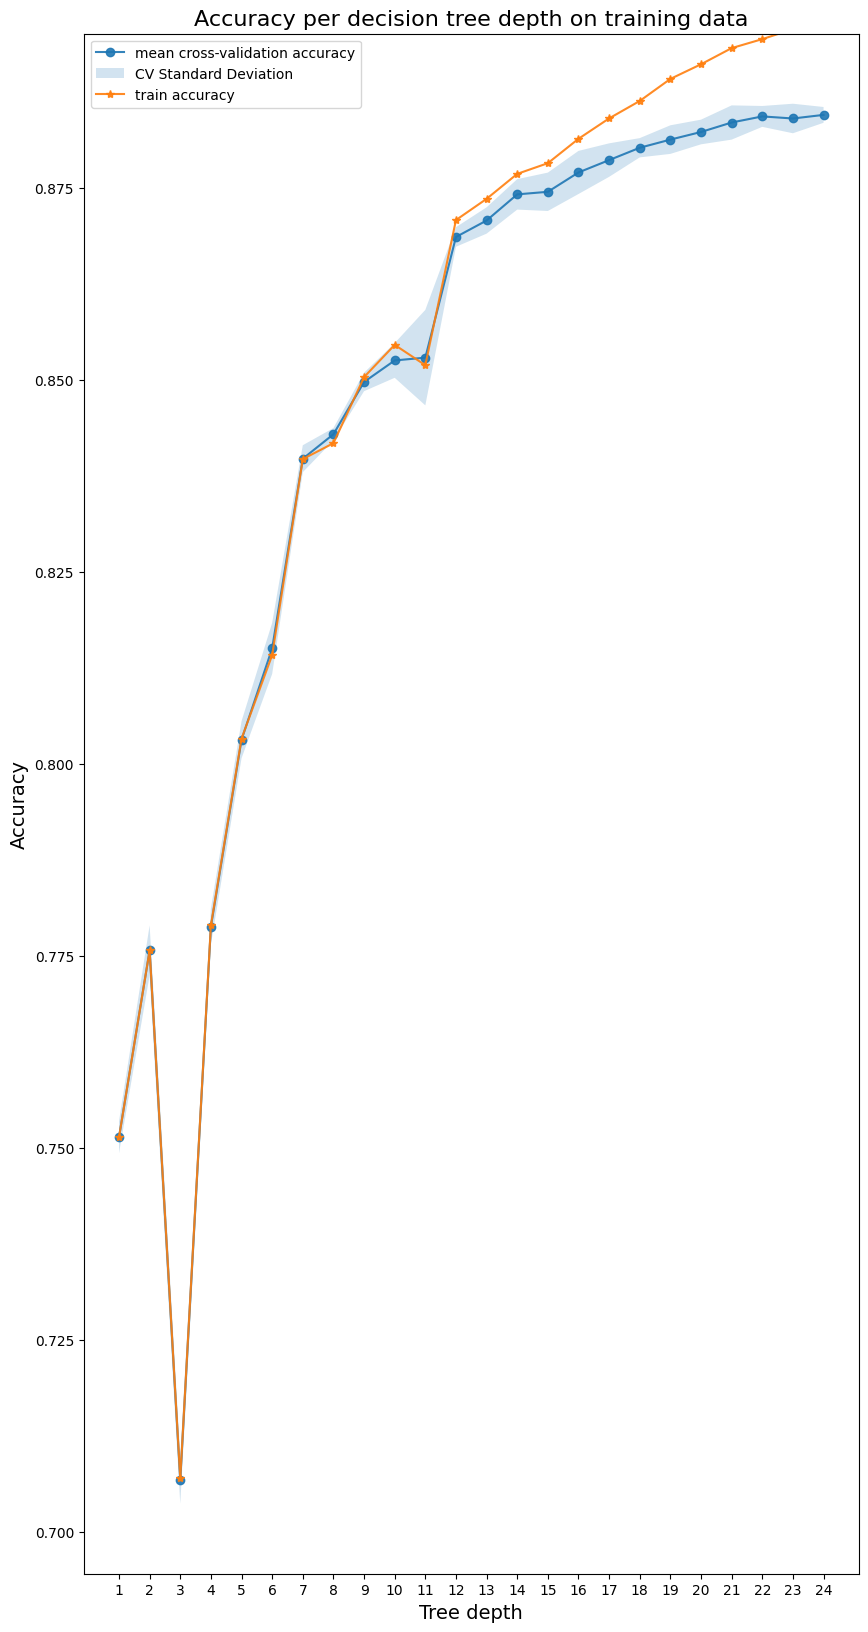

In [64]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, 
                                   cv_scores_mean, 
                                   cv_scores_std, 
                                   accuracy_scores, 
                                   title):
    
    fig, ax = plt.subplots(1,1, figsize=(10,20))
    ax.plot(depths, cv_scores_mean, '-o', 
            label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, 
                    cv_scores_mean-2*cv_scores_std, 
                    cv_scores_mean+2*cv_scores_std, alpha=0.2, label='CV Standard Deviation')
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, 
                               sm_cv_scores_mean, 
                               sm_cv_scores_std, 
                               sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [65]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset.'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))


The depth-24 tree achieves the best mean cross-validation accuracy 88.45345 +/- 0.05148% on training dataset.


In [66]:
# function for training and evaluating a tree
def run_single_tree(X_train, y_train, X_test, y_test, depth):
    model = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Single tree depth: ', depth)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return accuracy_train, accuracy_test
  

# train and evaluate a 23-depth tree
sm_best_tree_accuracy_train, sm_best_tree_accuracy_test = run_single_tree(X_train, 
                                                                          y_train, 
                                                                          X_test, 
                                                                          y_test, 
                                                                          sm_best_tree_depth)

Single tree depth:  24
Accuracy, Training Set:  89.74147 %
Accuracy, Test Set:  88.61094 %


In [67]:
# Saving fine-tuned trained decision tree

dtree = DecisionTreeClassifier(max_depth=sm_best_tree_depth)

dtree = dtree.fit(X_train, y_train)

In [68]:
print('% change from untuned accuracy:', perc_increase(dtree_score, dtree.score(X_test, y_test)))

% change from untuned accuracy: 0.2040497360377894


In [69]:
print('FINE-TUNED DECISION TREE F1-SCORE:')
f1_score(y_test, dtree.predict(X_test), average = 'weighted')

FINE-TUNED DECISION TREE F1-SCORE:


0.8810894137384198

In [70]:
# Lists where we append predicted and actual labels based on output of function above
dtree_predicted_labels = []
dtree_actual_labels = []

for i in dtree.predict(X_test):
    dtree_predicted_labels.append(get_pred(i))

for i in y_test.values:
    dtree_actual_labels.append(get_pred(i))

## Tuning stopping conditions in Decision Tree

Already tuned `max_depth` by cross-validating. Current concern is that because we have *not* specified `max_leaf_nodes` our decision tree is performing a *depth-first search*, which is unoptimal. We perform a grid-search in order to find the optimal parameter, but also take the opportunity to tune other stopping conditions such as `min_sample_leafs` and `min_impurity_decrease`, which can only help the classification process. The searching process then switches from "depth-first" to "best-first". 

We ran the code below on the same machine we used to tune random forest, and obtained the results stored in `dtree_best_params`. We then use these to train a Decision Tree Classifier, which is in theory optimal. 

In [71]:
# # Set the range of values for the parameters
# param_grid = {
#     'min_sample_leafs': [1, 5, 10, 20, 50],
#     'max_leaf_nodes': [2, 5, 10, 20, 50],
#     'min_impurity_decrease': [0, 0.1, 0.2, 0.5, 1]
#     }

# dtree = DecisionTreeClassifier(max_depth=23)

# # Use grid search to find the best combination of parameters
# grid_search = GridSearchCV(dtree, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Print the best combination of parameters
# print(grid_search.best_params_)


In [72]:
dtree_best_params = {'max_leaf_nodes': 50, 
                     'min_impurity_decrease': 0, 
                     'min_samples_leaf': 1}

# Recall the result from our cross-validation
best_depth = {'max_depth':23}

# Complete parameter grid, fine-tuned
dtree_best_params.update(best_depth)
print(dtree_best_params)

{'max_leaf_nodes': 50, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'max_depth': 23}


In [73]:
dtree_optimal = DecisionTreeClassifier(max_leaf_nodes = 50,
                                       min_impurity_decrease = 0, 
                                       min_samples_leaf = 1, 
                                       max_depth =23)

dtree_optimal = dtree_optimal.fit(X_train, y_train)

In [74]:
print('Accuracy of Gridsearched Decision Tree:', dtree_optimal.score(X_test, y_test))

Accuracy of Gridsearched Decision Tree: 0.8424204731301684


## Gridsearch for hyperparameter tuning of Random Forest

The `RandomForestClassifier` was our best performing model without any tuning, with an accuracy of $\approx 89%$. We looked to improve it by choosing the optimal parameters with a `RandomSearch`. This proved itself extremely computationally expensive, leading us to running it on a different machine with over 60GB of RAM, which still took roughly 300 minutes. The code we used to run it has been commented out, but the resulting parameters were stored in `best_params`, which we then used and obtained a $0.05%$ increase in accuracy from our un-tuned model. 

In [75]:
rf = RandomForestClassifier(random_state = 42)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [76]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [77]:
# %%time

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 3, 
#                                verbose=2, 
#                                random_state=42, 
#                                n_jobs = -1)


# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [78]:
%%time

best_params_rf =     {'n_estimators':100,
                     'min_samples_split':5,
                     'min_samples_leaf_':1,
                     'max_features':'sqrt',
                     'max_depth':46,
                     'bootstrap':True}

# Instantiating RF Classifier with these parameters:

rf_best_params = RandomForestClassifier(
                     n_estimators=100,
                     min_samples_split=5,
                     min_samples_leaf=1,
                     max_features='sqrt',
                     max_depth=46,
                     bootstrap=True).fit(X_train, y_train)

CPU times: user 43.7 s, sys: 294 ms, total: 44 s
Wall time: 44 s


In [79]:
print('ACCURACY SCORE GRIDSEARCHED RANDOM FOREST:')
print(rf_best_params.score(X_test, y_test))

ACCURACY SCORE GRIDSEARCHED RANDOM FOREST:
0.8919371309669146


In [80]:
print('F1-SCORE RANDOM FOREST:')
print(f1_score(y_test, rf_best_params.predict(X_test), average='weighted'))

F1-SCORE RANDOM FOREST:
0.8865898014306564


In [81]:
# Recording base accuracy from before
base_accuracy = rf_score


# Recording accuracy of gridsearched 
random_accuracy = rf_best_params.score(X_test, y_test)

### Confusion Matrix

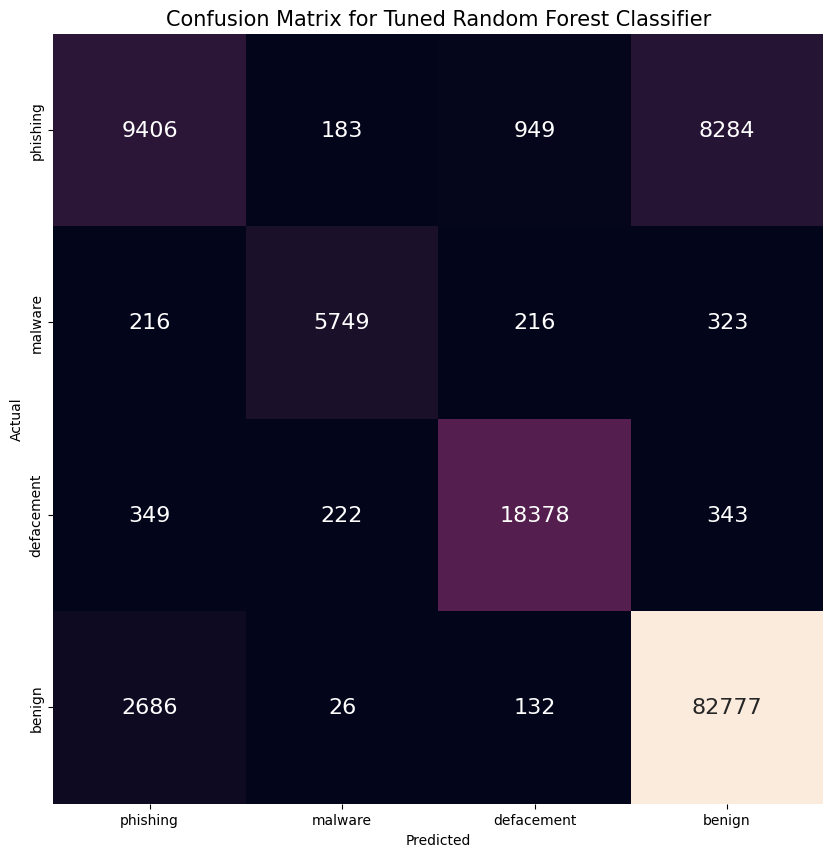

In [82]:
# Creating the confusion matrix
cm_rf_tuned = confusion_matrix(actual_labels, 
                         [get_pred(i) for i in rf_best_params.predict(X_test)], 
                         labels=dependent_variables)

df_cm_rf_tuned = pd.DataFrame(cm_rf_tuned, labels, labels)
plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix for Tuned Random Forest Classifier', fontsize=15)
ax = sns.heatmap(df_cm_rf_tuned, 
                 annot=True, 
                 annot_kws={'size': 16}, 
                 square=True, 
                 cbar=False, fmt='g')

ax.set_ylim(0, 4) 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
ax.invert_yaxis() 
plt.show()

In [83]:
# Classification report:

print('\nClassification Fine-Tuned Report Random Forest\n')
print(classification_report(actual_labels, [get_pred(i) for i in rf_best_params.predict(X_test)]))


Classification Fine-Tuned Report Random Forest

              precision    recall  f1-score   support

      benign       0.90      0.97      0.93     85621
  defacement       0.93      0.95      0.94     19292
     malware       0.93      0.88      0.91      6504
    phishing       0.74      0.50      0.60     18822

    accuracy                           0.89    130239
   macro avg       0.88      0.83      0.85    130239
weighted avg       0.89      0.89      0.89    130239



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


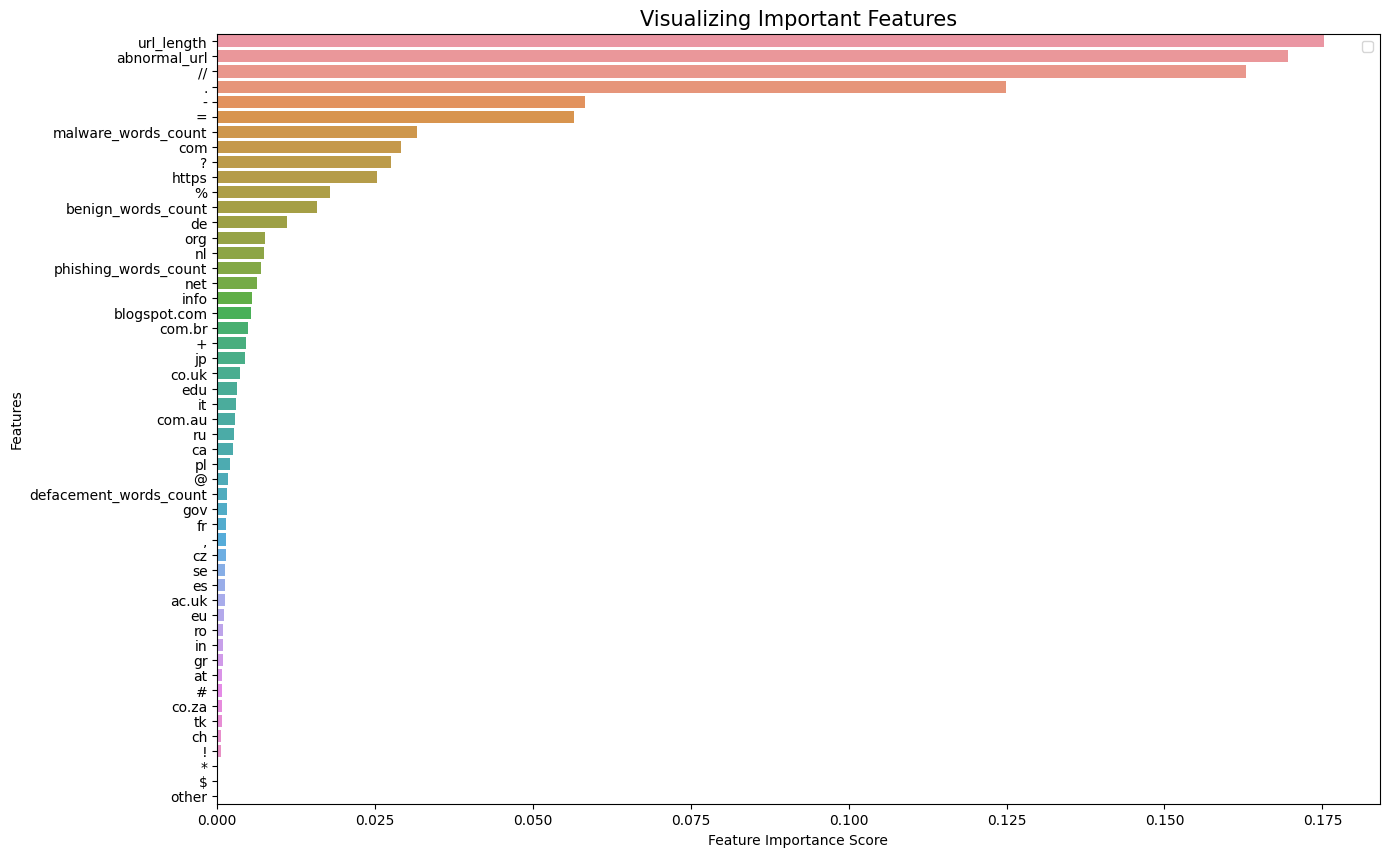

In [108]:
# Inspecting feature importance

feature_imp = pd.Series(rf_best_params.feature_importances_, index=predictors).sort_values(ascending=False)
pd.DataFrame(feature_imp, columns=['Feature Importance Score']).head(5)

# Visualizing feature importance

# Creating a bar plot
plt.figure(figsize=(15,10))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", fontsize=15)
plt.legend()
plt.show()

### Exporting RF Classifier as preferred Model

In [84]:
# save Fine-Tuned Random Forest Classifier to disk to use in GUI

filename = 'tuned_rf.sav'
pickle.dump(rf_best_params, open(filename, 'wb'))
 

# Other models

## XGboost

In [85]:
%%time

bst = XGBClassifier(n_estimators=500,
                    learning_rate=0.8)


bst.fit(X_train, y_train)

CPU times: user 33min 33s, sys: 4min 56s, total: 38min 29s
Wall time: 4min 30s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.8, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [86]:
print('XGBoost Accuracy Score:', bst.score(X_test, y_test))

XGBoost Accuracy Score: 0.8857101175531139


In [87]:
print("Best Iteration: {}".format(bst.get_booster().best_iteration))

Best Iteration: 499


In [88]:
print('F1-SCORE XGBOOST:')
print(f1_score(y_test, bst.predict(X_test), average='weighted'))

F1-SCORE XGBOOST:
0.8856405161614064


The `learning_rate` parameter above was inferred from tuning the XGBoost model with the code below. The code takes a few hours to run. Hence, for simplicity, we don't run it again, and take it as given from now on. 

We also went one step further and performed a Randomized Search to further tune the `n_estimators` parameter. We obtain a value of 350 as optimal. However, this seems to give us a worse accuracy than our original guess of 500. Hence, we assume a positive correlation between `n_estimators` and accuracy, and decide to keep that.  

In [89]:
# %%time

# # We are going to tune for the learning rate

# rs = [0.2, 0.4, 0.6, 0.8, 1]
# accuracies = []

# for r in rs:
#     XGB = XGBClassifier(n_estimators=500,
#                     learning_rate=r)
#     XGB.fit(X_train, y_train)
#     accuracies.append(XGB.score(X_test, y_test))

# highest_xgb_test_accuracy = np.max(accuracies)
# best_learning_rate_XGB = rs[np.argmax(accuracies)]

# print(f"Max XGB accuracy is: {highest_xgb_test_accuracy}. Obtained for LR of: {best_learning_rate_XGB}")

In [90]:
# n_estimators = range(50, 400, 50)
# param_grid = dict(n_estimators=n_estimators)


# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# xg = XGBClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# xg_random = RandomizedSearchCV(estimator = xg, 
#                                param_distributions = param_grid, 
#                                n_iter = 100, 
#                                cv = 3)

# xg_random.fit(X_train, y_train)

In [91]:
# Initialising XGBoost classifier using parameters from gridsearch
bst_tuned = XGBClassifier(n_estimators=350,
                                learning_rate=0.8)

bst_tuned = bst_tuned.fit(X_train, y_train)

In [92]:
print('FINE TUNED XGBOOST SCORE:')
print(bst_tuned.score(X_test, y_test))

FINE TUNED XGBOOST SCORE:
0.8848424818986632


## AdaBoost

In [93]:
%%time

# Instantiating AdaBoost

# Default depth of DTree Classifier is `none` --> we input it as 1 to have "stumps" at each iteration
# as AdaBoost is a combination of "weak" learners

base_model = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
ada = AdaBoostClassifier(base_estimator=base_model, n_estimators=500)

# Training AdaBoost, making sure to fit it on our modified version of y_train
ada = ada.fit(X_train, numerical_y_train)

CPU times: user 1min 33s, sys: 8.81 s, total: 1min 42s
Wall time: 1min 41s


In [94]:
y_pred_ada = ada.predict(X_test)

ada_score = accuracy_score(np.array(numerical_y_test), y_pred_ada)

print('ADABOOST ACCURACY SCORE:', ada_score)


ADABOOST ACCURACY SCORE: 0.8101951028493769


In [95]:
print('F1-SCORE ADABOOST:')
print(f1_score(numerical_y_test, ada.predict(X_test), average='weighted'))

F1-SCORE ADABOOST:
0.7704658806587388


In [96]:
# # create an AdaBoost classifier
# ada = AdaBoostClassifier()

# # specify the hyperparameter values to search over
# param_grid = {
#     'base_estimator': [DecisionTreeClassifier(max_depth=1), 
#                        DecisionTreeClassifier(max_depth=2)],
#     'n_estimators': [50, 100, 150, 200],
#     'learning_rate': [0.5, 1.0, 1.5, 2.0]
# }

# # create the GridSearchCV object
# grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='accuracy')

# # fit the grid search object to the training data
# grid_search.fit(X_train, numerical_y_train)

# # print the best hyperparameters found
# print(grid_search.best_params_)


In [97]:
best_params_ada = {'base_estimator': DecisionTreeClassifier(max_depth=2),
                   'learning_rate': 0.5, 'n_estimators': 500}

tuned_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), 
                               n_estimators=500,
                              learning_rate= 0.5)

tuned_ada = tuned_ada.fit(X_train, numerical_y_train)

In [98]:
print('TUNED ADABOOST CLASSIFIER SCORE:')
print(tuned_ada.score(X_test,  numerical_y_test))

TUNED ADABOOST CLASSIFIER SCORE:
0.817980789164536


In [99]:
print('TUNED ADABOOST CLASSIFIER F1-SCORE:')
print(f1_score(numerical_y_test, tuned_ada.predict(X_test), average= 'weighted'))

TUNED ADABOOST CLASSIFIER F1-SCORE:
0.7855919394743611


# Results of Tuned Models

Accuracy and F1-score are both metrics used to evaluate the performance of a classification model. The main difference between these two metrics is that accuracy is a ratio of the number of correct predictions made by the model to the total number of predictions, while the F1-score is a weighted average of the precision and recall of the model.

For simplicity, we have used the latter of the two throughout this analysis. However, awareness of the class imbalance regarding our categories has led us to equally consider the `f1_score` throughout, in order to corroborate it. The differences between the two have been negligible, this can be observed in our final plot comparing results.

In the `results_df_final` DataFrame we display our final results, which we then plot. Our best performing model, both in a tuned and un-tuned setting was the **Random Forest Classifier**. Multiple properties of this model can be invoked here which explain its performance. The one we focus on is the comparison to its counterpart, the tuned and un-tuned decision trees: a large number of relatively weak learners operating as a committee will most likely outperform any of the individual constituent trees. The complexity of the decision boundaries being very high (as we have a very large number of features), with the differences between categories of URLs being very subtle, depending on a majority vote of an ensemble of decision trees as opposed to a single one seems to be a more reliable strategy, even if the individual tree is a stronger learner (which we achieved with a depth-24 decision tree). 


We assume that this is why even by cross-validating for the depth of our decision tree, the random forest classifier is able to outperform it. 

Also, our Random Forest is most likely more equipped to avoid overfitting in this case. This is because each decision tree in the ensemble is trained on a different subset of the data, and the final prediction is made by averaging the predictions of all the decision trees. This means that the random forest classifier is less likely to be affected by noisy or outlier data points, which can improve the overall performance of the model. 

Another point that is worth raising here is that we were unable to make our single decision tree outperform our Random Forest even by grid searching it. We conducted an exhaustive search of hyperparameters, and our accuracy still decreased compared to our base model. This means that the default hyperparameters for the decision tree were more appropriate to this scenario than the ones we obtained via gridsearch. This means that there is still a possibility that there exist better hyperparameters, but also a possibility that there are *not*.

In a bid to try and achieve an even higher accuracy, we further train AdaBoost and XGBoost Classifiers. 

In [101]:
# Defining a function to give us the f1-score without having to specify additional params

f1 = lambda y_test, y_pred: f1_score(y_test, 
                                     y_pred, 
                                     average = 'weighted')

In [102]:
print('FINAL RESULTS, RANKED BY TEST ACCURACY:')

results_ = {
    'Fine-Tuned Random Forest Classifier': [rf_best_params.score(X_test, y_test), 
    f1(y_test, rf_best_params.predict(X_test))], 
    'Fine-Tuned Decision Tree Classifier':[sm_best_tree_accuracy_test, f1(y_test, 
                                                                          dtree.predict(X_test))],
    'Fine-Tuned XGBoost':[bst.score(X_test, y_test), f1(y_test, 
                                                        bst.predict(X_test))], 
    'Fine-Tuned AdaBoost':[tuned_ada.score(X_test, numerical_y_test), f1(numerical_y_test, 
                                                                         ada.predict(X_test))]
            }

results_df_final = pd.DataFrame.from_dict(results_, orient = 'index')
results_df_final.columns =['Test Accuracy', 'F1-Score']
results_df_final.sort_values(by='Test Accuracy', ascending=False)

FINAL RESULTS, RANKED BY TEST ACCURACY:


,Test Accuracy,F1-Score
Fine-Tuned Random Forest Classifier,0.891937,0.886590
Fine-Tuned Decision Tree Classifier,0.886109,0.881089
Fine-Tuned XGBoost,0.885710,0.885641
Fine-Tuned AdaBoost,0.817981,0.770466


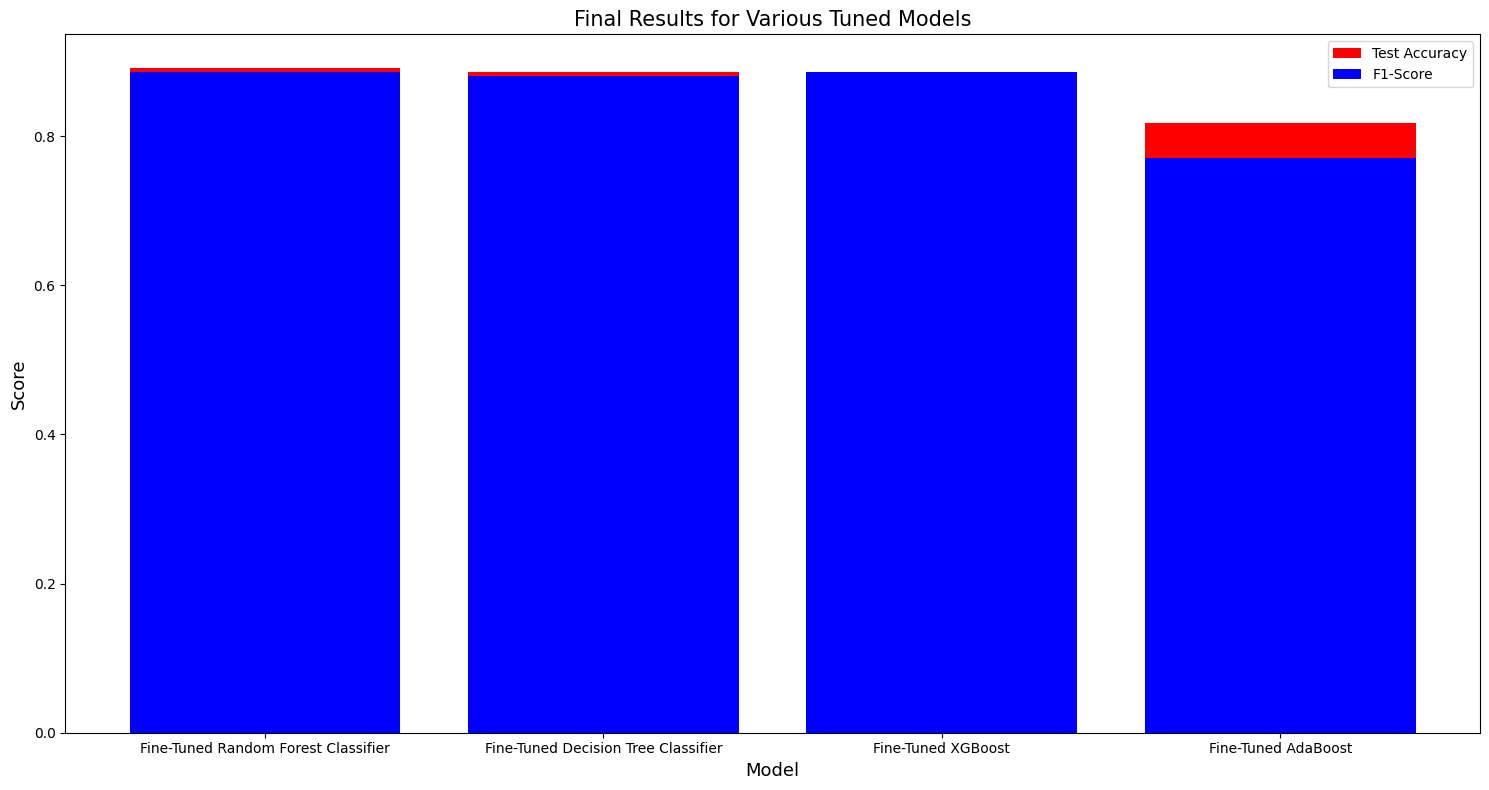

In [103]:
plt.figure(figsize=(15,8 ))
plt.xlabel('Model', fontsize = 13)
plt.ylabel('Score', fontsize=13)
plt.bar(results_df_final.index, results_df_final['Test Accuracy'], 
        color='r', label='Test Accuracy')
plt.bar(results_df_final.index, results_df_final['F1-Score'], 
        color='b', label='F1-Score')
plt.title('Final Results for Various Tuned Models', fontsize=15)
plt.tight_layout()
plt.legend();

# Going further...

## Multi-layer perceptron

A multilayer perceptron (MLP) classifier is a type of artificial neural network that can be used for classification tasks. It trains using Stochastic Gradient Descent, Adam, or L-BFGS. 

Because MLP classifiers are able to learn and make predictions based on patterns in the input data, they can potentially be trained to recognize the characteristics of malicious URLs and make predictions about the likelihood that a given URL is malicious. This can be an effective way to detect and prevent potential security threats.

For our case, we select the L-BFGS solver. One advantage of using the limited-memory Broyden–Fletcher–Goldfarb–Shanno (LBFGS) solver for training a multi-layer perceptron (MLP) is that it typically converges faster than other first-order optimization algorithms, such as stochastic gradient descent (SGD). Another advantage of the LBFGS solver is that it is well-suited for high-dimensional optimization problems, which is the case with our dataset.


LBGFS is a quasi-Newton method: it uses an approximation of the Hessian matrix to make updates to the model's parameters, rather than computing the Hessian. General form of quasi-Newton methods:
$$
  x_{k+1} = x_k - \alpha_k B_k^{-1}\nabla f(x_k) $$

where $\alpha_k$ is a line search parameter and
$B_k$ is some approximation to the Hessian. 

The Broyden–Fletcher–Goldfarb–Shanno (BFGS) method
is one of the most popular quasi-Newton methods:


1:$\hspace{0em}$ choose initial guess $x_0$  
2:$\hspace{0em}$ choose $B_0$, initial guess for Hessian, e.g. $B_0 = {\rm I}$  
3:$\hspace{0em}$ for $k = 0,1,2,\ldots$ do  
4:$\hspace{1.2em}$ solve $B_k s_k = -\nabla f(x_k)$  
5:$\hspace{1.2em}$$ x_{k+1} = x_k + s_k$  
6:$\hspace{1.2em}$$ y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$  
7:$\hspace{1.2em}$$ B_{k+1} = B_k + \Delta B_k$  
8:$\hspace{0em}$ end for  




where $\Delta B_k = \frac{y_ky_k^T}{y_k^Ts_k} - \frac{B_k s_k s_k^T B_k}{s_k^T B_ks_k}$

In our implementation of this model we set `hidden_layer_sizes` =(26,) - denoting only 1 hidden layer with 26 hidden neurons. These specifications were made based on Sarle’s (2002) comments on neural networks. According to our research, 1 hidden layer is a commonly accepted starting point when it comes to tuning the MLP’s.

In [104]:
neural_network = MLPClassifier(solver='lbfgs', alpha=1e-3,
                     hidden_layer_sizes=(26,), 
                    random_state=1, 
                    max_iter=10000)

In [105]:
%%time

neural_network.fit(X_train, y_train)

CPU times: user 3h 30min 30s, sys: 20min 42s, total: 3h 51min 12s
Wall time: 25min 34s


MLPClassifier(alpha=0.001, hidden_layer_sizes=(26,), max_iter=10000,
              random_state=1, solver='lbfgs')

In [106]:
print('MLP Accuracy Score:')
print(neural_network.score(X_test, y_test))

MLP Accuracy Score:
0.8199924753722003


In [107]:
print('MLP F1-Score:')
print(f1_score(y_test, neural_network.predict(X_test), average='weighted'))

MLP F1-Score:
0.7981241191954997


## What can be done to further improve our results?

A significant issue that we came across while performing hyperparameter tuning was that some of our tuned-models performed worse than our un-tuned/partially tuned ones. We assumed that this was simply because our classifiers were already performing strongly, and the list of hyper-parameters they were told to select from was not exhaustive enough. 

We could have given our gridsearches more parameters to choose from. However, our gridsearches were already way too computationally expensive as such, with an average of 5+ hours to run each gridsearch. 

What we would like to do in a future iteration of our project is to run these algorithms in a High-Performance-Computing setting, using for example Amazon Sagemaker from the AWS Machine Learning family. Sagemaker enables you to mount a jupyter notebook on a server with a CPU of your choice. Running hyperparameter tuning in the Cloud would then enable us to consider a wider range of hyperparameters, thus significantly increasing our chances to improve F1-scores and accuracies of our already-high-performing models.  

From AWS: https://aws.amazon.com/sagemaker/automatic-model-tuning/

"Amazon SageMaker Automatic Model Tuning (also known as hyperparameter tuning or hyperparameter optimization) finds the best version of your machine learning (ML) model by running multiple training jobs on your dataset using your specified algorithm and hyperparameter ranges.  It then chooses the hyperparameter values that result in the best performing model, as determined by your chosen metric.  You specify an ML model to tune, your objective metric, and the hyperparameters to search, and SageMaker Automatic Model Tuning finds a better version of the model in the most cost-effective way".